In [1]:
import os
os.environ["DDE_BACKEND"] = "pytorch"  # Set backend to PyTorch before importing deepxde

In [2]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [3]:
# Set constants
q0, p0 = 1, 1
Tmin, Tmax = -2, 2
w_low, w_high = 1, 3


The solution for the harmonic oscillator is $x(t) = q_0 \cos(\omega t) + \frac{p_0}{\omega}\sin(\omega t)$

In [4]:
# Get analytical solution of the BVP for given t and omega
def analytic_solution(w, t, q0=q0, p0=p0):
    return q0*np.cos(w @ t.T) + p0*np.diag(1/w.flatten())@np.sin(w @ t.T)

# Returns a (len(w), len(t))-shape matrix

In [5]:
# Create training data
w_train = np.random.uniform(low=w_low, high=w_high, size=150).reshape(-1, 1)
t_train = np.random.uniform(low=Tmin, high=Tmax, size=100).reshape(-1, 1)
y_train = analytic_solution(w_train, t_train).astype(np.float32)
X_train = (w_train.astype(np.float32), t_train.astype(np.float32))

In [6]:
# Create testing data
w_test = np.random.uniform(low=w_low, high=w_high, size=150).reshape(-1, 1)
t_test = np.random.uniform(low=Tmin, high=Tmax, size=100).reshape(-1, 1)
y_test = analytic_solution(w_test, t_test).astype(np.float32)
X_test = (w_test.astype(np.float32), t_test.astype(np.float32))

In [7]:
# Compile train- and test data into a tensor 
data = dde.data.TripleCartesianProd(
    X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test
)

In [8]:
# Specify network architecture
m = 1       # number of sensors
dim_x = 1   # dimensionality of BVP
net = dde.nn.DeepONetCartesianProd(
    [m, 40, 40],
    [dim_x, 40, 40],
    "relu",
    "Glorot normal",
)

In [9]:
# Create the model
model = dde.Model(data, net)

In [10]:
# Compile and train
model.compile("adam", lr=0.001, metrics=["mean l2 relative error"])
losshistory, train_state = model.train(iterations=10000)

Compiling model...
'compile' took 0.489418 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [6.51e-01]    [6.40e-01]    [9.92e-01]    
1000      [3.29e-03]    [3.08e-03]    [6.52e-02]    
2000      [2.46e-03]    [2.17e-03]    [5.48e-02]    
3000      [2.30e-03]    [2.04e-03]    [5.30e-02]    
4000      [2.18e-03]    [1.93e-03]    [5.14e-02]    
5000      [2.07e-03]    [1.83e-03]    [5.01e-02]    
6000      [2.01e-03]    [1.75e-03]    [4.87e-02]    
7000      [1.82e-03]    [1.58e-03]    [4.66e-02]    
8000      [1.65e-03]    [1.44e-03]    [4.43e-02]    
9000      [1.39e-03]    [1.22e-03]    [4.06e-02]    
10000     [1.19e-03]    [1.06e-03]    [3.76e-02]    

Best model at step 10000:
  train loss: 1.19e-03
  test loss: 1.06e-03
  test metric: [3.76e-02]

'train' took 4.590205 s



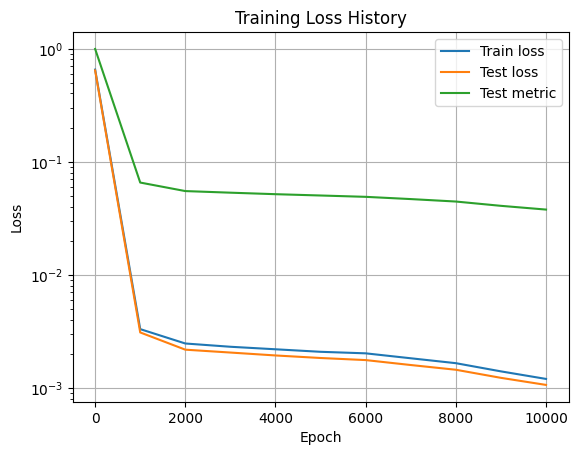

In [11]:
# Plot the loss trajectory
dde.utils.plot_loss_history(losshistory)
plt.title("Training Loss History")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

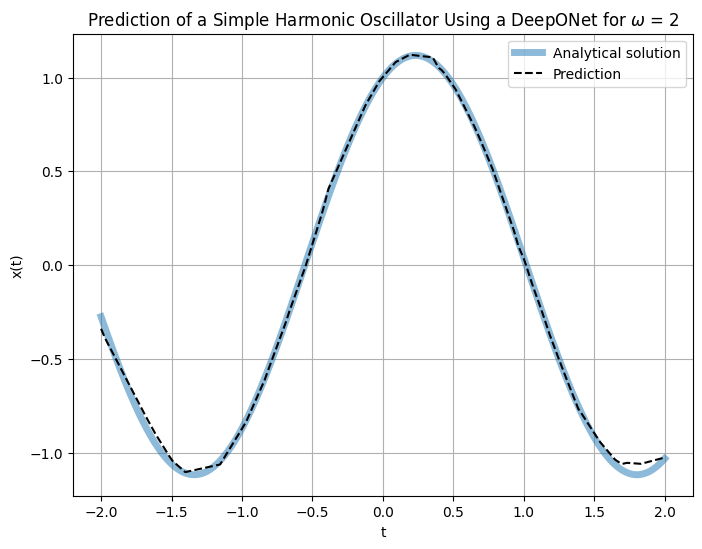

In [12]:
# Plot model prediction for one omega

# Get model prediction
w = np.array([2]).reshape(-1, 1)
t = np.linspace(Tmin, Tmax, 1000).reshape(-1, 1)
pred = model.predict((w, t))

# Get corresponding ground truth
ground_truth = analytic_solution(w, t)

# Plot prediction vs. solution
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(t.flatten(), ground_truth.flatten(), label='Analytical solution', alpha=0.5, linewidth=5)
ax.plot(t.flatten(), pred.flatten(), '--', label='Prediction', c='k')
ax.set_title('Prediction of a Simple Harmonic Oscillator Using a DeepONet for $\omega$ = 2')
ax.set_xlabel("t")
ax.set_ylabel("x(t)")
ax.legend()
ax.grid(True)
plt.show()